#Automatizacion del proceso de toma de decisiones para la aprobación de líneas de crédito




##Importacion librerias

In [ ]:
#Librerias para manipulacion de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("dark_background")
#Librerias para metricas
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
import time
#Librerras para Preprocesado y holdout
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
#Librerias de los modelos a utilizar
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.svm import SVC


##Importacion el Data Set

In [ ]:
#Se obtiene el Dataset en un pandas.DataFrame almacenado en la variable df.
df=pd.read_csv("https://raw.githubusercontent.com/ragnor-devop/demo_day_data_sets/main/01%20Data_Set_Banco/01%20credit_train_v03.csv")
#Se obtiene los datos de prueba
dftest = pd.read_csv("https://raw.githubusercontent.com/ragnor-devop/demo_day_data_sets/main/01%20credit_test.csv")

##Exploracion de datos

In [ ]:
# Forma del dataset
df.shape


(100000, 19)

In [ ]:
# Los primeros 4 registros del dataset
df.head(4)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0


In [ ]:
#Resumen del Dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Loan Amount,99990.0,1.176160e+07,3.178532e+07,10802.0,179652.00,312246.000,524942.00,1.000000e+08
Credit Score,80838.0,1.076410e+03,1.475301e+03,585.0,705.00,724.000,741.00,7.510000e+03
Annual Income,80838.0,1.378267e+06,1.081395e+06,76627.0,848844.00,1174076.500,1650691.50,1.655574e+08
Monthly Debt,99990.0,1.847260e+04,1.217520e+04,0.0,10214.21,16221.155,24012.01,4.358433e+05
Years of Credit History,99990.0,1.819823e+01,7.014741e+00,3.6,13.50,16.900,21.70,7.050000e+01
Months since last delinquent,46854.0,3.490065e+01,2.199818e+01,0.0,16.00,32.000,51.00,1.760000e+02
Number of Open Accounts,99990.0,1.112851e+01,5.009845e+00,0.0,8.00,10.000,14.00,7.600000e+01
Number of Credit Problems,99990.0,1.683268e-01,4.827262e-01,0.0,0.00,0.000,0.00,1.500000e+01
Current Credit Balance,99990.0,2.946374e+05,3.761808e+05,0.0,112670.00,209826.500,367949.25,3.287897e+07
Maximum Open Credit,99988.0,7.608121e+05,8.384921e+06,0.0,273438.00,467885.000,782958.00,1.539738e+09


##Preprocesado de datos

In [ ]:
'''
Se elimina las siguientes columnas:
Loan ID 
Costumer ID
Los ids al ser valores unicos no aportan al entrenamiento de los modelos
'''
df=df.drop(columns=["Loan ID","Customer ID"])

#Lo mismo para los datos de testeo
dftest = dftest.drop(columns=["Loan ID","Customer ID"])

In [ ]:
#Eliminacion los registros duplicados 
df=df.drop_duplicates()
#Lo mismo para los datos de testeo
dftest=dftest.drop_duplicates()

In [ ]:
#Nueva cantidad de registros
df.shape

(89778, 17)

In [ ]:
# Datos de testeo se eliminan los valores nulos
dftest=dftest.dropna()

In [ ]:
#Cuantificacion de los registros con valores nulos para los datos de testeo
dftest.isna().sum()

Current Loan Amount             0
Term                            0
Credit Score                    0
Annual Income                   0
Years in current job            0
Home Ownership                  0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
dtype: int64

In [ ]:
# forma del dataset de testeo
dftest.shape

(3573, 16)

In [ ]:
#Cuantificacion de los registros con valores nulos
df.isna().sum()


Loan Status                         1
Current Loan Amount                 1
Term                                1
Credit Score                    19153
Annual Income                   19153
Years in current job             3803
Home Ownership                      1
Purpose                             1
Monthly Debt                        1
Years of Credit History             1
Months since last delinquent    48334
Number of Open Accounts             1
Number of Credit Problems           1
Current Credit Balance              1
Maximum Open Credit                 3
Bankruptcies                      191
Tax Liens                          10
dtype: int64

In [ ]:
'''
Se rellena las columnas con valores promedio
'''
df=df.fillna(df.mean())
#Lo mismo para los datos de testeo
dftest = dftest.fillna(dftest.mean())

In [ ]:
#Cuantificacion los registros con valores nulos
df.isna().sum()

Loan Status                        1
Current Loan Amount                0
Term                               1
Credit Score                       0
Annual Income                      0
Years in current job            3803
Home Ownership                     1
Purpose                            1
Monthly Debt                       0
Years of Credit History            0
Months since last delinquent       0
Number of Open Accounts            0
Number of Credit Problems          0
Current Credit Balance             0
Maximum Open Credit                0
Bankruptcies                       0
Tax Liens                          0
dtype: int64

In [ ]:
#Analisis de la siguiente columna con registros categoricos
df.groupby(["Years in current job"]).count()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Years in current job,,,,,,,,,,,,,,,,
1 year,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831
10+ years,27753,27753,27753,27753,27753,27753,27753,27753,27753,27753,27753,27753,27753,27753,27753,27753
2 years,8254,8254,8254,8254,8254,8254,8254,8254,8254,8254,8254,8254,8254,8254,8254,8254
3 years,7337,7337,7337,7337,7337,7337,7337,7337,7337,7337,7337,7337,7337,7337,7337,7337
4 years,5511,5511,5511,5511,5511,5511,5511,5511,5511,5511,5511,5511,5511,5511,5511,5511
5 years,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135
6 years,5134,5134,5134,5134,5134,5134,5134,5134,5134,5134,5134,5134,5134,5134,5134,5134
7 years,4988,4988,4988,4988,4988,4988,4988,4988,4988,4988,4988,4988,4988,4988,4988,4988
8 years,4121,4121,4121,4121,4121,4121,4121,4121,4121,4121,4121,4121,4121,4121,4121,4121


In [ ]:
#Transformar la columna "Years in current job"de object en float al extraer los caracteres no numericos
df['Years in current job']=df['Years in current job'].str.extract(r"(\d+)")
df['Years in current job'] =df['Years in current job'].astype(float)
#Lo mismo para los datos de testeo

dftest['Years in current job'] = dftest['Years in current job'].str.extract(r"(\d+)")
dftest['Years in current job'] = dftest['Years in current job'].astype(float)

In [ ]:
#Eliminar los registros nulos 
df=df.dropna()

In [ ]:
#Cuantificar los registros con valores nulos
df.isna().sum()

Loan Status                     0
Current Loan Amount             0
Term                            0
Credit Score                    0
Annual Income                   0
Years in current job            0
Home Ownership                  0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
dtype: int64

In [ ]:
#Resumen del Dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Loan Amount,85975.0,1.313251e+07,3.337096e+07,10802.0,185559.00000,3.201220e+05,5.361400e+05,1.000000e+08
Credit Score,85975.0,1.126774e+03,1.385249e+03,585.0,715.00000,7.370000e+02,1.130771e+03,7.510000e+03
Annual Income,85975.0,1.392133e+06,9.926143e+05,76627.0,949905.00000,1.375888e+06,1.512286e+06,1.655574e+08
Years in current job,85975.0,5.961803e+00,3.500504e+00,1.0,3.00000,6.000000e+00,1.000000e+01,1.000000e+01
Monthly Debt,85975.0,1.862531e+04,1.220123e+04,0.0,10391.95500,1.634760e+04,2.414587e+04,4.358433e+05
Years of Credit History,85975.0,1.804291e+01,6.816498e+00,3.6,13.40000,1.690000e+01,2.150000e+01,7.050000e+01
Months since last delinquent,85975.0,3.493207e+01,1.496074e+01,0.0,34.97522,3.497522e+01,3.497522e+01,1.760000e+02
Number of Open Accounts,85975.0,1.117688e+01,5.009871e+00,0.0,8.00000,1.000000e+01,1.400000e+01,7.600000e+01
Number of Credit Problems,85975.0,1.588950e-01,4.691662e-01,0.0,0.00000,0.000000e+00,0.000000e+00,1.500000e+01
Current Credit Balance,85975.0,2.962465e+05,3.738455e+05,0.0,114484.50000,2.120020e+05,3.706615e+05,3.287897e+07


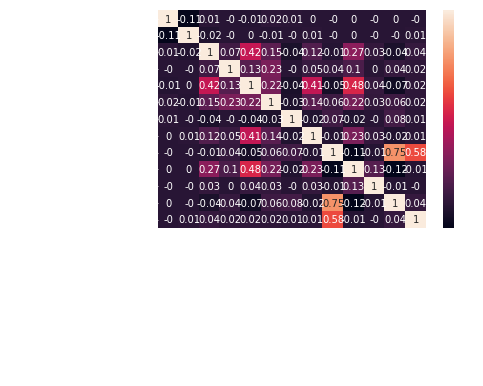

In [ ]:
#Mariz de correlacion
dfc=df.copy()
dfc=dfc.corr()
dfc=dfc.round(2)
sns.heatmap(dfc,annot=True,fmt=".2g");

##Matriz de Correlacion


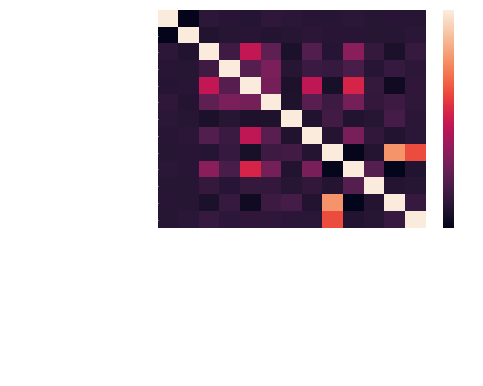

In [ ]:
sns.heatmap(df.corr());

##Analisis de Columna


Las columnas" **Term**","**Home Ownership**", "**Purpose**" tienen datos categoricos, asi que se llevan a datos numericos asi tambien el target "**Loan Status**" Utilizando las librerias OneHotencoder y ColumnTransfer


In [ ]:
# Clases para la columna "Term"
df.groupby("Term").count()

,Loan Status,Current Loan Amount,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Term,,,,,,,,,,,,,,,,
Long Term,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168
Short Term,62807,62807,62807,62807,62807,62807,62807,62807,62807,62807,62807,62807,62807,62807,62807,62807


In [ ]:
# Clases para la columna "Home Ownership"
df.groupby("Home Ownership").count()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Home Ownership,,,,,,,,,,,,,,,,
HaveMortgage,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176
Home Mortgage,41814,41814,41814,41814,41814,41814,41814,41814,41814,41814,41814,41814,41814,41814,41814,41814
Own Home,7521,7521,7521,7521,7521,7521,7521,7521,7521,7521,7521,7521,7521,7521,7521,7521
Rent,36464,36464,36464,36464,36464,36464,36464,36464,36464,36464,36464,36464,36464,36464,36464,36464


In [ ]:
dftest.groupby("Home Ownership").count()

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Home Ownership,,,,,,,,,,,,,,,
HaveMortgage,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Home Mortgage,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853
Own Home,297,297,297,297,297,297,297,297,297,297,297,297,297,297,297
Rent,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419


In [ ]:
# Clases para la columna "Purpose"
df.groupby("Purpose").count()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Purpose,,,,,,,,,,,,,,,,
Business Loan,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336
Buy House,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561,561
Buy a Car,1116,1116,1116,1116,1116,1116,1116,1116,1116,1116,1116,1116,1116,1116,1116,1116
Debt Consolidation,67987,67987,67987,67987,67987,67987,67987,67987,67987,67987,67987,67987,67987,67987,67987,67987
Educational Expenses,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87
Home Improvements,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957,4957
Medical Bills,906,906,906,906,906,906,906,906,906,906,906,906,906,906,906,906
Other,2760,2760,2760,2760,2760,2760,2760,2760,2760,2760,2760,2760,2760,2760,2760,2760
Take a Trip,463,463,463,463,463,463,463,463,463,463,463,463,463,463,463,463


In [ ]:
# Clases para la columna "Loan Status"
df.groupby("Loan Status").count()

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
Loan Status,,,,,,,,,,,,,,,,
Charged Off,21363,21363,21363,21363,21363,21363,21363,21363,21363,21363,21363,21363,21363,21363,21363,21363
Fully Paid,64612,64612,64612,64612,64612,64612,64612,64612,64612,64612,64612,64612,64612,64612,64612,64612


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


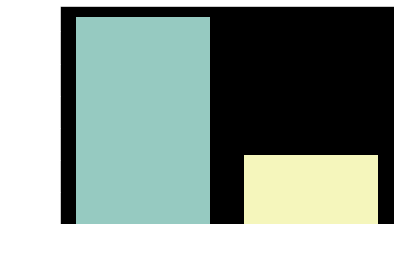

In [ ]:
sns.countplot(df["Loan Status"])

In [ ]:
# Calculo de la cantidad de columnas nuevas del dataset de entrenamiento que tienen valores categoricos
cterm=df.groupby("Term").count().shape[0]
chome=df.groupby("Home Ownership").count().shape[0]
cPurpose=df.groupby("Purpose").count().shape[0]
cloan=df.groupby("Loan Status").count().shape[0]
print(f"Total de clases para las columnas"
      f" Term = {cterm}"
      f" Home Ownership = {chome}"
      f" Purpose = {cPurpose}|" 
      f" Loan Status = {cloan}\n"
      f"Total columnas = {cterm+chome+cPurpose+cloan} ")

Total de clases para las columnas Term = 2 Home Ownership = 4 Purpose = 15| Loan Status = 2
Total columnas = 23 


In [ ]:
# Calculo de la cantidad de columnas nuevas del dataset de testeo que tienen valores categoricos
cterm=dftest.groupby("Term").count().shape[0]
chome=dftest.groupby("Home Ownership").count().shape[0]
cPurpose=dftest.groupby("Purpose").count().shape[0]
print(f"Total de clases para las columnas"
      f" Term = {cterm}"
      f" Home Ownership = {chome}"
      f" Purpose = {cPurpose}\n" 
      f"Total columnas = {cterm+chome+cPurpose} ")

Total de clases para las columnas Term = 2 Home Ownership = 4 Purpose = 15
Total columnas = 21 


##Column Transformer

In [ ]:
#Transformar valores categoricos a valores numericos
columnas=df.columns

categoricos = ['Loan Status','Term','Home Ownership','Purpose']
ct = ColumnTransformer([('transform', OneHotEncoder(), categoricos )],  remainder = 'passthrough')
t=  np.array(ct.fit_transform(df), dtype = np.float)

#Lo mismo para los datos de testeo
categoricos = ['Term','Home Ownership','Purpose']
ct_test = ColumnTransformer([('transform', OneHotEncoder(), categoricos )],  remainder = 'passthrough')
t_test=  np.array(ct_test.fit_transform(dftest), dtype = np.float)


In [ ]:
# Nueva forma del dataset
df=pd.DataFrame(t)
df.head(7)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,445412.0,709.000000,1.167493e+06,8.0,5214.74,17.2,34.97522,6.0,1.0,228190.0,416746.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262328.0,1130.770591,1.375888e+06,10.0,33295.98,21.1,8.00000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99999999.0,741.000000,2.231892e+06,8.0,29200.53,14.9,29.00000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347666.0,721.000000,8.069490e+05,3.0,8741.90,12.0,34.97522,9.0,0.0,256329.0,386958.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176220.0,1130.770591,1.375888e+06,5.0,20639.70,6.1,34.97522,15.0,0.0,253460.0,427174.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206602.0,7290.000000,8.968570e+05,10.0,16367.74,17.3,34.97522,6.0,0.0,215308.0,272448.0,0.0,0.0
6,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217646.0,730.000000,1.184194e+06,1.0,10855.08,19.6,10.00000,13.0,1.0,122170.0,272052.0,1.0,0.0


In [ ]:
# Renombrar los nombres de las columnas
rename={0:'Charged Off',1:'Fully Paid',2:'Long Term',3:'Short Term',4:'Have Mortage',5:'Home Mortgage',6:'Own Home', 7:'Rent'
        ,8:'Business Loan', 9:'Buy House', 10:'Buy a Car', 11:'Debt Consolidation',12:'Educational Expenses'
        ,13:'Home Improvements',14:'Medical Bills', 15:'Other',16:'Take a Trip', 17:'major_purchase'
        ,18:'moving',19:'other', 20:'small_business', 21:'vacation',22:'wedding'
        ,23:"Loan Amount", 24:'credit score',25:'Annaual InCOME',26:'Years in current Job',27:'monthly debt'
        ,28:'credit history',29:'Months since last delinquent',30:'Open account',31:'credit Problem'
        ,32:'Current credit balance',33:'Maximum open credit',34:'Bankruptcies',35:'Tax Liens', }

df.rename(columns=rename,inplace=True)
df.head(7)

,Charged Off,Fully Paid,Long Term,Short Term,Have Mortage,Home Mortgage,Own Home,Rent,Business Loan,Buy House,Buy a Car,Debt Consolidation,Educational Expenses,Home Improvements,Medical Bills,Other,Take a Trip,major_purchase,moving,other,small_business,vacation,wedding,Loan Amount,credit score,Annaual InCOME,Years in current Job,monthly debt,credit history,Months since last delinquent,Open account,credit Problem,Current credit balance,Maximum open credit,Bankruptcies,Tax Liens
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,445412.0,709.000000,1.167493e+06,8.0,5214.74,17.2,34.97522,6.0,1.0,228190.0,416746.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262328.0,1130.770591,1.375888e+06,10.0,33295.98,21.1,8.00000,35.0,0.0,229976.0,850784.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99999999.0,741.000000,2.231892e+06,8.0,29200.53,14.9,29.00000,18.0,1.0,297996.0,750090.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347666.0,721.000000,8.069490e+05,3.0,8741.90,12.0,34.97522,9.0,0.0,256329.0,386958.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176220.0,1130.770591,1.375888e+06,5.0,20639.70,6.1,34.97522,15.0,0.0,253460.0,427174.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206602.0,7290.000000,8.968570e+05,10.0,16367.74,17.3,34.97522,6.0,0.0,215308.0,272448.0,0.0,0.0
6,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217646.0,730.000000,1.184194e+06,1.0,10855.08,19.6,10.00000,13.0,1.0,122170.0,272052.0,1.0,0.0


In [ ]:
#Eliminacion de las variables ficticias
df.drop(columns=['Charged Off', 'Long Term', 'Have Mortage', 'vacation'], axis=1, inplace=True)


In [ ]:
#dataset transfomado con el ColumnTransformer y OnehotEncoder
dftest=pd.DataFrame(t_test)
dftest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153494.0,709.0,871112.0,2.0,8391.73,12.5,10.0,10.0,0.0,38532.0,388036.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176242.0,727.0,780083.0,10.0,16771.87,16.5,27.0,16.0,1.0,156940.0,531322.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,321992.0,744.0,1761148.0,10.0,39478.77,26.0,44.0,14.0,0.0,359765.0,468072.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,266288.0,683.0,2031518.0,2.0,12443.10,24.4,56.0,8.0,2.0,31445.0,251130.0,2.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258104.0,723.0,1284514.0,7.0,6368.99,14.6,64.0,12.0,0.0,128402.0,266904.0,0.0,0.0


In [ ]:
#Lo mismo para los datos de testeo renonbrar las columnas.
rename={0:'Long Term',1:'Short Term',2:'Have Mortage',3:'Home Mortgage',4:'Own Home', 5:'Rent'
        ,6:'Business Loan', 7:'Buy House', 8:'Buy a Car', 9:'Debt Consolidation',10:'Educational Expenses'
        ,11:'Home Improvements',12:'Medical Bills', 13:'Other',14:'Take a Trip', 15:'major_purchase'
        ,16:'moving',17:'other', 18:'small_business', 19:'vacation',20:'wedding'
        ,21:"Loan Amount", 22:'credit score',23:'Annaual InCOME',24:'Years in current Job',25:'monthly debt'
        ,26:'credit history',27:'Months since last delinquent',28:'Open account',29:'credit Problem'
        ,30:'Current credit balance',31:'Maximum open credit',32:'Bankruptcies',33:'Tax Liens'}
dftest = pd.DataFrame(t_test)
dftest.rename(columns=rename,inplace=True)
dftest.head()

,Long Term,Short Term,Have Mortage,Home Mortgage,Own Home,Rent,Business Loan,Buy House,Buy a Car,Debt Consolidation,Educational Expenses,Home Improvements,Medical Bills,Other,Take a Trip,major_purchase,moving,other,small_business,vacation,wedding,Loan Amount,credit score,Annaual InCOME,Years in current Job,monthly debt,credit history,Months since last delinquent,Open account,credit Problem,Current credit balance,Maximum open credit,Bankruptcies,Tax Liens
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153494.0,709.0,871112.0,2.0,8391.73,12.5,10.0,10.0,0.0,38532.0,388036.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176242.0,727.0,780083.0,10.0,16771.87,16.5,27.0,16.0,1.0,156940.0,531322.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,321992.0,744.0,1761148.0,10.0,39478.77,26.0,44.0,14.0,0.0,359765.0,468072.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,266288.0,683.0,2031518.0,2.0,12443.10,24.4,56.0,8.0,2.0,31445.0,251130.0,2.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258104.0,723.0,1284514.0,7.0,6368.99,14.6,64.0,12.0,0.0,128402.0,266904.0,0.0,0.0


In [ ]:
#Eliminacion de las variables ficticias en los datos de testeo
dftest.drop(columns=['Long Term', 'Have Mortage', 'vacation'], axis=1, inplace=True)

In [ ]:
#Forma final del dataset
df.shape

(85975, 32)

##Holdout del dataset

In [ ]:
#Holdout de los datos
y=df["Fully Paid"]
X=df.drop(columns=["Fully Paid"])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=33)

In [ ]:
# Forma de los datos de entrenamiento
X_train.shape

(57603, 31)

In [ ]:
#Forma de los datos de prueba
X_test.shape

(28372, 31)

##Normalizacion de los datos


In [ ]:
# Forma de los datos de entrenamiento
X_train.head(7)

,Short Term,Home Mortgage,Own Home,Rent,Business Loan,Buy House,Buy a Car,Debt Consolidation,Educational Expenses,Home Improvements,Medical Bills,Other,Take a Trip,major_purchase,moving,other,small_business,wedding,Loan Amount,credit score,Annaual InCOME,Years in current Job,monthly debt,credit history,Months since last delinquent,Open account,credit Problem,Current credit balance,Maximum open credit,Bankruptcies,Tax Liens
49717,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99999999.0,710.0,1016044.0,6.0,15579.43,23.9,34.97522,18.0,0.0,369987.0,732336.0,0.0,0.0
32112,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,355124.0,736.0,1734795.0,3.0,40767.92,34.2,59.00000,14.0,0.0,280649.0,481426.0,0.0,0.0
62805,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,323334.0,738.0,1202263.0,10.0,12824.05,17.7,34.97522,8.0,0.0,361798.0,505362.0,0.0,0.0
44371,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,266684.0,692.0,998070.0,5.0,24452.81,13.7,34.97522,7.0,0.0,219469.0,284570.0,0.0,0.0
52798,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99999999.0,703.0,1674774.0,6.0,26935.92,22.1,71.00000,16.0,0.0,4049033.0,13589422.0,0.0,0.0
53384,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88814.0,744.0,706629.0,3.0,14544.69,9.7,47.00000,11.0,0.0,26923.0,77550.0,0.0,0.0
55012,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99999999.0,735.0,904609.0,5.0,16192.56,14.5,34.97522,8.0,0.0,391951.0,726110.0,0.0,0.0


In [ ]:
# Se recupera en Xcolumns los nombres de las columnas
Xcolumnas=X_train.columns


In [ ]:
# Normalizacion de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#Lo mismo para los datos de testeo
X_test = scaler.transform(X_test)
#lo mismo para los datos de prueba
X_pruebas=scaler.transform(dftest)


In [ ]:
# Transformar a un pandas.DataFrame los datos de entrenamiento
X_train=pd.DataFrame(data=X_train,columns=Xcolumnas)
X_test=pd.DataFrame(data=X_test,columns=Xcolumnas)
#Lo mismo para los datos de testeo
X_pruebas=pd.DataFrame(data=dftest.to_numpy(),columns=dftest.columns)


##**Implementacion de los modelos**


###Funcion grafica Matriz de confusion

In [ ]:
def make_confusion_matrix(matriz,
                          grupo_nombres=["Verdad Neg","Falso Pos","Falso Neg",'Verdad Pos'],
                          categorias='auto',
                          cantidades=True,
                          porcentaje=True,
                          cbar=True,
                          xyValores=True,
                          xyEtiquetas=True,
                          stats=True,
                          figsize=None,
                          cmap='Blues',
                          titulo=None):
    '''
    Funcion para graficar la matriz de confusion utilizando la libreria seaborn
    Arguments
    ---------
    matriz:        Matriz de confusion.
    grupo_nombres:   Lista de cadena que representan las etiquetas de cada fila en cada caja.
    categorias:    Lista de cadenas que contienen las categorias para mostrar en los ejes x,y. Default="auto"
    
    cantidades:         Si es True, muestra un numero que representa la cantidad de cada caja de la matriz de confusion. Default=True
    porcentaje:    Si es True, muesta las proporciones de cada categoria, Default=True
    
    cbar:          Si es True, muesta la barra de color. Los valores se basan en los valores de la matriz de confusion, Default=True

    xyValoress:    Si es True, Muesta los valores en los ejes X,Y Default=True.
    xyEtiquetas:   Si es True, Muestra la etiqueda "True" y "Predicted" en la grafica Deful=True.
    stats:         Si es True, muestra los valores estadisticos debajo la grafica.
    figsize:       Tupla representa la escala de la grafica (Definido por la libreria matplolib) Default=plt.rcParams.get('figure.figsize')
    cmap:          Colores de los valores mostrados (Definido por la libreria matplolib)(matplotlib.pyplot.cm.) Default="Blues"
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    titulo:         Titulo para la grafica. Default = None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blancos = ['' for i in range(matriz.size)]

    if grupo_nombres and len(grupo_nombres)==matriz.size:
        grupo_etiquetas = ["{}\n".format(value) for value in grupo_nombres]
    else:
        grupo_etiquetas = blancos

    if cantidades:
        grupo_counts = ["{0:0.0f}\n".format(value) for value in matriz.flatten()]
    else:
        grupo_counts = blancos

    if porcentaje:
        grupo_porcentajes = ["{0:.2%}".format(value) for value in matriz.flatten()/np.sum(matriz)]
    else:
        grupo_percentajes = blancos

    caja_etiquetas = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(grupo_etiquetas,grupo_counts,grupo_porcentajes)]
    caja_etiquetas = np.asarray(caja_etiquetas).reshape(matriz.shape[0],matriz.shape[1])


    # ESTADISTICAS
    if stats:
        #Accuarcy es la suma de la diagonal dividido por el total de observaciones
        
        accuraccy  = np.trace(matriz) / float(np.sum(matriz))
        # Si es matriz binaria se su muesta mas estadisticas
        
        if len(matriz)==2:
            #Metrics for Binary Confusion Matrices
            precision = matriz[1,1] / sum(matriz[:,1])
            recall    = matriz[1,1] / sum(matriz[1,:])
            f1_sc  = 2*precision*recall / (precision + recall)
            # f1_sc=f1_score(y_true,y_pred,average="binary")
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuraccy,precision,recall,f1_sc)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuraccy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyValores==False:
        #Do not show categories if xyticks is False
        categorias=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(matriz,annot=caja_etiquetas,fmt="",cmap=cmap,cbar=cbar,xticklabels=categorias,yticklabels=categorias)

    if xyEtiquetas:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if titulo:
        plt.title(titulo)

###**Logistic Regression**

####Entrenamiento Logistic Regression

In [ ]:
#Implementcion del modelo Logistic Regression para la prediccion de los datos
#utilizar variables: X_train, y_train, X_test, Y_test

logistic_regresion = LogisticRegression(max_iter=10000)



In [ ]:
#Entrenamiento del modelo Logistic Regression
lr_entrenamiento_tiempo_inicio= time.time()
logistic_regresion.fit(X_train, y_train)
lr_entrenamiento_tiempo_fin = time.time()
logistic_regression_tiempo_entrenamiento = lr_entrenamiento_tiempo_fin - lr_entrenamiento_tiempo_inicio # in seconds
print(f"Tiempo de ejecucion para Entrenamiento Logistic Regression: {logistic_regression_tiempo_entrenamiento:,.3f} ")

Tiempo de ejecucion para Entrenamiento Logistic Regression: 1.068 


#### Prediccion Logistic Regression

In [ ]:
# prediccion Logistic Regression
lr_predict_tiempo_inicio= time.time()
y_pred_regression = logistic_regresion.predict(X_test)
lr_predict_tiempo_fin = time.time()
logistic_regression_tiempo_prediccion = lr_predict_tiempo_fin - lr_predict_tiempo_inicio # in seconds
print(f"Tiempo de ejecucion para Prediccion Random Forest: {logistic_regression_tiempo_prediccion:,.3f} ")

Tiempo de ejecucion para Prediccion Random Forest: 0.003 


####Precision Logistic Regression

In [ ]:
#Metricas Accuracy Score Logistic Regression
accuracy_logistic_regression = accuracy_score(y_test, y_pred_regression)
accuracy_logistic_regression

0.8008600028196814

####Cross Validation Score Logistic Regression

In [ ]:
#Metricas con Cross Validation Score
accuracies_crosval_regression = cross_val_score(estimator = logistic_regresion,X = X, y = y,cv=13)
accuracies_crosval_regression.mean()

0.7977435875252717

#### Matriz de Confusion Logistic Regression

In [ ]:
#Metricas Matriz de confusion Logistic Regression
matriz_logistic_regression = confusion_matrix(y_test, y_pred_regression)
matriz_logistic_regression

array([[ 1525,  5584],
       [   66, 21197]])

In [ ]:
#Metricas F1 Score
f1_sc_regression=f1_score(y_test,y_pred_regression,average="binary")
f1_sc_regression

0.8823994671551079

####Grafica Matriz Confusion Logistic Regression

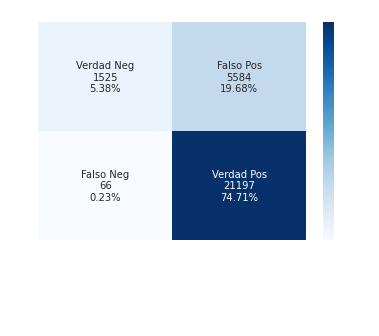

In [ ]:
#Grafica Matriz de Confusion
make_confusion_matrix(matriz_logistic_regression,titulo="Logistic Regression Matriz")

Interpretacion de la matriz

- Verdadero Negativo: Donde el 5.38 % de los casos reales los prestamos no son factibles y la predicción coincide.
- Verdadero Positivo: Donde el 74.71% de los casos reales de los prestamos son factibles y la predicción coincide.
- Falso Positivo: Donde el 19.68% de los casos reales de los prestamos no son factibles y la predicción no coincide.
- Falso Negativo: Donde el 0.23% de los casos reales de los prestamos son factibles y la predicción dice lo contrario. 

###**Random Forest**

#### Entrenemiento Random Forest

In [ ]:
# Implementcion del modelo Random Forest para la prediccion de los datos
#utilizar variables: X_train, y_train, X_test, Y_test
random_forest = RandomForestClassifier(criterion="entropy",class_weight="balanced")

In [ ]:
#Entreamiento modelo Random Forest
rf_entrenamiento_inicio_tiempo = time.time()
random_forest.fit(X_train, y_train)
rf_entrenamiento_fin_tiempo = time.time()
random_forest_tiempo_entrenamiento = rf_entrenamiento_fin_tiempo-rf_entrenamiento_inicio_tiempo # in seconds
print(f"Tiempo de ejecucion para entrenamiento Random Forest: {random_forest_tiempo_entrenamiento:,.3f} ")

Tiempo de ejecucion para entrenamiento Random Forest: 20.697 


#### Prediccion Random Forest

In [ ]:
# prediccion Random Forest
rf_predict_tiempo_inicio = time.time()
y_pred_random_forest = random_forest.predict(X_test)
rf_predict_tiempo_fin = time.time()
random_forest_tiempo_prediccion = rf_predict_tiempo_fin - rf_predict_tiempo_inicio # in seconds
print(f"Tiempo de ejecucion para Prediccion Random Forest: {random_forest_tiempo_prediccion:,.3f} ")

Tiempo de ejecucion para Prediccion Random Forest: 0.894 


#### Precision Random Forest

In [ ]:
#Metricas Accuracy Score Random Forest
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("Accuracy ", accuracy_random_forest)

Accuracy  0.8016001691808826


####Cross Validation Score Random Forest

In [ ]:
#Metricas con Cross Validation
accuracies_crosval_random_forest=cross_val_score(estimator=random_forest,X=X,y=y,cv=13)

In [ ]:
accuracies_crosval_random_forest.mean()

0.802326348233282

#### Matriz de confusion Random Forest

In [ ]:
#Metricas Matriz de confusion Random Forest
matriz_random_forest = confusion_matrix(y_test, y_pred_random_forest)
matriz_random_forest

array([[ 1742,  5367],
       [  251, 21012]])

In [ ]:
#Metricas F1 Score
f1_sc_random_forest=f1_score(y_test,y_pred_random_forest,average="binary")
f1_sc_random_forest

0.882078838000084

####Grafica Matriz de confusion Random Forest

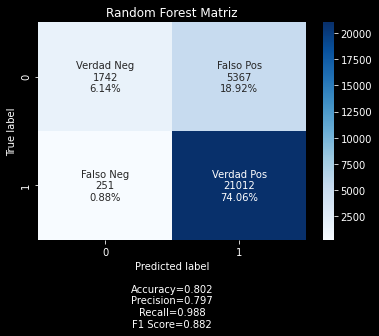

In [ ]:
#Grafica Matriz de Confusion
make_confusion_matrix(matriz_random_forest,titulo="Random Forest Matriz")

Interpretacion de la matriz

- Verdadero Negativo: Donde el 6.14% de los casos reales los prestamos no son factibles y la prediccion coincide.
- Verdadero Positivo: Donde el 73.99% de los casos reales de los prestamos son factibles y la prediccion coincide.
- Falso Positivo: Donde el 18.92% de los casos reales de los prestamos no son factibles y la prediccion no coincide.
- Falso Negativo: Donde el 0.88% de los casos reales de los prestamos son factibles y la prediccion dice lo contrario.

###**Support Vector Machine**

####Entrenamiento SVM

In [ ]:
# Implementcion del modelo support vector machine para la prediccion de los datos
#utilizar variables: X_train, y_train, X_test, Y_test
support_vector_machine = SVC()

In [ ]:
# Entrenamiento Support Vector Machine
svm_entrenamiento_inicio = time.time()
support_vector_machine.fit(X_train, y_train)
svm_entrenamiento_fin_tiempo = time.time()
svm_tiempo_entrenamiento = svm_entrenamiento_fin_tiempo-svm_entrenamiento_inicio # in seconds
print(f"Tiempo de ejecucion para entrenamiento Support Vector Machine: {svm_tiempo_entrenamiento:,.3f} ")


Tiempo de ejecucion para entrenamiento Support Vector Machine: 836.288 


####Prediccion SVM

In [ ]:
# prediccion support vector machine
svm_predict_tiempo_inicio = time.time()
y_pred_support_vector_machine = support_vector_machine.predict(X_test)
svm_predict_tiempo_fin = time.time()
svm_tiempo_prediccion = svm_predict_tiempo_fin - svm_predict_tiempo_inicio # in seconds
print(f"Tiempo de ejecucion para Prediccion Support Vector Machine: {svm_tiempo_prediccion:,.3f} ")

In [ ]:
#Metricas Accuracy Score support vector machine
accuracy_support_vector_machine = accuracy_score(y_test, y_pred_support_vector_machine)
print("Accuracy ", accuracy_support_vector_machine)

####Cross Validation Score SVM

In [ ]:
#Metricas con Cross Validation Demora demasiado
accuracies_crosval_svm=cross_val_score(estimator=support_vector_machine,X=X,y=y,cv=13)
accuracies_crosval_svm.mean()

####Matriz de confusion SVM

In [ ]:
#Metricas Matriz de confusion support vector machine
matriz_support_vector_machine = confusion_matrix(y_test, y_pred_support_vector_machine)
matriz_support_vector_machine

array([[ 1459,  5650],
       [   12, 21251]])

In [ ]:
#Metricas F1 Score
f1_sc_svm=f1_score(y_test,y_pred_support_vector_machine,average="binary")
f1_sc_svm

0.8824433186612407

####Grafica Matriz de confusion SVM

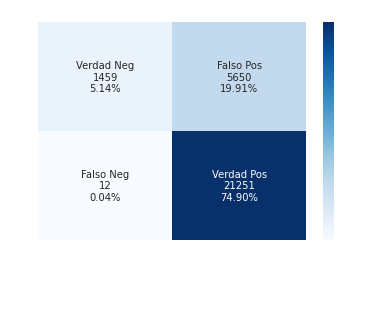

In [ ]:
#Grafica Matriz de Confusion
make_confusion_matrix(matriz_support_vector_machine,titulo="Support Vector Machine Matriz")

Interpretacion de la matriz

- Verdadero Negativo: Donde el 5.14% de los casos reales los prestamos no son factibles y la prediccion coincide.
- Verdadero Positivo: Donde el 74.90% de los casos reales de los prestamos son factibles y la prediccion coincide.
- Falso Positivo: Donde el 19.91% de los casos reales de los prestamos no son factibles y la prediccion no coincide.
- Falso Negativo: Donde el 0.04% de los casos reales de los prestamos son factibles y la prediccion dice lo contrario.

###Grafico de comparacion Precision

In [ ]:
df_resultados = pd.DataFrame({'model': ['Support Vector Machine','Logistic Regression', 'Random Forest'],
                        'score': [accuracy_support_vector_machine,accuracy_logistic_regression,accuracy_random_forest]})


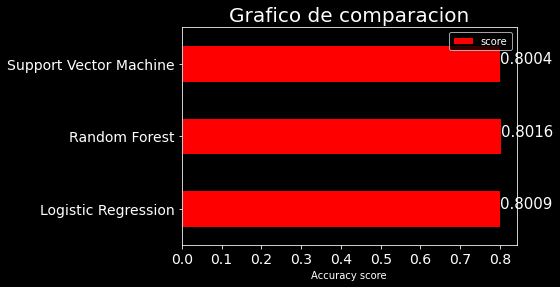

In [ ]:
df_resultados.plot(x = 'model',y = 'score', kind = 'barh',
                     color = 'red', edgecolor = 'black');
for i,rows in df_resultados.iterrows():
  
  plt.annotate(f"{rows['score']:,.4f}",xy=(rows['score'],i),rotation=0,color="white",size=15);

plt.ylabel('');
plt.yticks(size = 14); 
plt.xlabel('Accuracy score'); plt.xticks(size = 14);
plt.title('Grafico de comparacion', size = 20);


###Grafico de comparacion de tiempo Entrenamiento

In [ ]:
df_res_entrenamiento = pd.DataFrame({'model': ['Logistic Regression', 'Random Forest', 'Support Vector Machine'],
                        'tiempo': [logistic_regression_tiempo_entrenamiento, 
                                  random_forest_tiempo_entrenamiento,
                                  svm_tiempo_entrenamiento]})

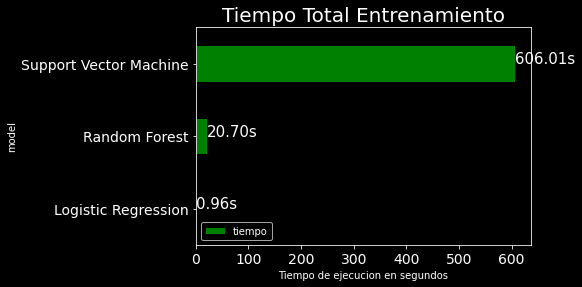

In [ ]:
df_res_entrenamiento.sort_values('tiempo', ascending = True).plot(x = 'model',y = 'tiempo', kind = 'barh',
                                                           color = 'green', edgecolor = 'black')
for i,rows in df_res_entrenamiento.iterrows():
    plt.annotate(f"{rows['tiempo']:,.2f}s",xy=(rows['tiempo'],i),rotation=0,color="white",size=15)

plt.yticks(size = 14); plt.xlabel('Tiempo de ejecucion en segundos'); plt.xticks(size = 14)
plt.title('Tiempo Total Entrenamiento', size = 20);

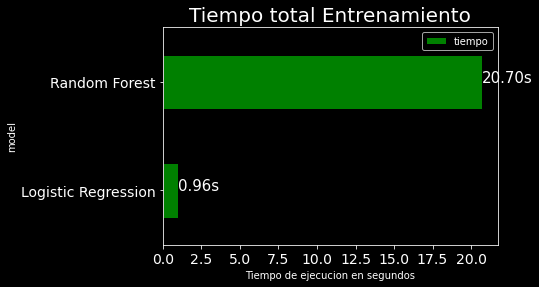

In [ ]:
df_res_entrenamiento = pd.DataFrame({'model': ['Logistic Regression', 'Random Forest'],
                        'tiempo': [logistic_regression_tiempo_entrenamiento, 
                                  random_forest_tiempo_entrenamiento]})
df_res_entrenamiento.sort_values('tiempo', ascending = True).plot(x = 'model',y = 'tiempo', kind = 'barh',
                                                           color = 'green', edgecolor = 'black')
for i,rows in df_res_entrenamiento.iterrows():
    plt.annotate(f"{rows['tiempo']:,.2f}s",xy=(rows['tiempo'],i),rotation=0,color="white",size=15)

plt.yticks(size = 14); plt.xlabel('Tiempo de ejecucion en segundos'); plt.xticks(size = 14)
plt.title('Tiempo total Entrenamiento', size = 20);

###Grafico de comparacion de tiempo Prediccion

In [ ]:
df_res_prediccion = pd.DataFrame({'model': ['Logistic Regression', 'Random Forest', 'Support Vector Machine'],
                        'tiempo': [logistic_regression_tiempo_prediccion, 
                                  random_forest_tiempo_prediccion,
                                  svm_tiempo_prediccion]})

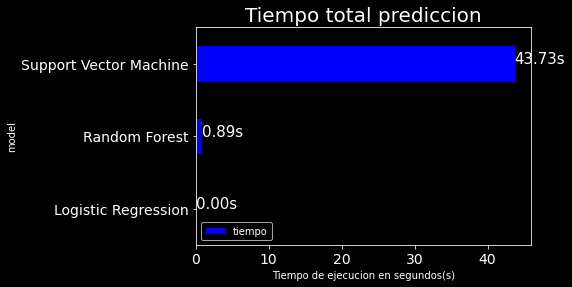

In [ ]:
df_res_prediccion.sort_values('tiempo', ascending = True).plot(x = 'model',y = 'tiempo', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')
for i,rows in df_res_prediccion.iterrows():
    plt.annotate(f"{rows['tiempo']:,.2f}s",xy=(rows['tiempo'],i),rotation=0,color="white",size=15)

plt.yticks(size = 14); plt.xlabel('Tiempo de ejecucion en segundos(s)'); plt.xticks(size = 14)
plt.title('Tiempo total prediccion', size = 20);

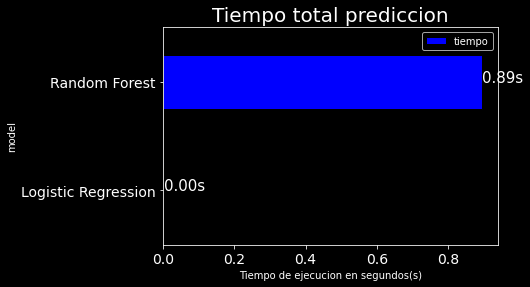

In [ ]:
df_res_prediccion = pd.DataFrame({'model': ['Logistic Regression', 'Random Forest'],
                        'tiempo': [logistic_regression_tiempo_prediccion, 
                                  random_forest_tiempo_prediccion]})
df_res_prediccion.sort_values('tiempo', ascending = True).plot(x = 'model',y = 'tiempo', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')
for i,rows in df_res_prediccion.iterrows():
    plt.annotate(f"{rows['tiempo']:,.2f}s",xy=(rows['tiempo'],i),rotation=0,color="white",size=15)

plt.yticks(size = 14); plt.xlabel('Tiempo de ejecucion en segundos(s)'); plt.xticks(size = 14)
plt.title('Tiempo total prediccion', size = 20);

##Datos de prueba

In [ ]:
# Recuperamos las columnas
cols=dftest.columns
cols

Index(['Short Term', 'Home Mortgage', 'Own Home', 'Rent', 'Business Loan',
       'Buy House', 'Buy a Car', 'Debt Consolidation', 'Educational Expenses',
       'Home Improvements', 'Medical Bills', 'Other', 'Take a Trip',
       'major_purchase', 'moving', 'other', 'small_business', 'wedding',
       'Loan Amount', 'credit score', 'Annaual InCOME', 'Years in current Job',
       'monthly debt', 'credit history', 'Months since last delinquent',
       'Open account', 'credit Problem', 'Current credit balance',
       'Maximum open credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [ ]:
y_pruebas_predict=logistic_regresion.predict(X_pruebas)
y_pruebas_predict


array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
# Datos prueba para probar lso modelos
datos=np.array([[1,#Short Term
                  1,0,0,#Home Mortgage,Own Home, Rent
                  0,0,0,1,#Business Loan,Buy House,Buy a Car,Debt Consolidation
                  0,0,0,0,#Educacional Expenses,Home Improvements,Medical Bills,Other
                  0,0,0,0,#Take a Trip,Major_Purchase,moving,other,
                  0,0,#Small_business,wedding
                  420000,7300,50000,2,2000,#Loan Amount,credit score,Annaual InCOME,Years in current Job,monthly debt
                  7,34,5,1,#credit history,Months since last delinquent,Open account,credit Problem
                  78000,420000,1,0]])#Current credit balance,Maximum open credit,Bankruptcies,Tax Liens

dfnuevo=pd.DataFrame(data=datos,columns=cols)       
X_nuevo=scaler.transform(dfnuevo)
X_nuevo=pd.DataFrame(data=X_nuevo,columns=cols)       
y_pruebas_pred=logistic_regresion.predict(X_nuevo)
y_conceder=pd.DataFrame(y_pruebas_pred,columns=["Aprobar"])
y_conceder

,Aprobar
0,0.0


In [ ]:
# Datos prueba para probar los modelos
datos=np.array([[1,#Short Term
                  0,1,0,#Home Mortgage,Own Home, Rent
                  0,0,0,1,#Business Loan,Buy House,Buy a Car,Debt Consolidation
                  0,0,0,0,#Educacional Expenses,Home Improvements,Medical Bills,Other
                  0,0,0,0,#Take a Trip,Major_Purchase,moving,other,
                  0,0,#Small_business,wedding
                  320000,700,90000,5,4400,#Loan Amount,credit score,Annaual InCOME,Years in current Job,monthly debt
                  7,34,5,1,#credit history,Months since last delinquent,Open account,credit Problem
                  78000,420000,0,0]])#Current credit balance,Maximum open credit,Bankruptcies,Tax Liens

dfnuevo=pd.DataFrame(data=datos,columns=cols)       
X_nuevo=scaler.transform(dfnuevo)
X_nuevo=pd.DataFrame(data=X_nuevo,columns=cols)       
y_pruebas_pred=logistic_regresion.predict(X_nuevo)
y_conceder=pd.DataFrame(y_pruebas_pred,columns=["Aprobar"])
y_conceder

,Aprobar
0,1.0


En el primer caso se refiere a una persona solicitante de un crédito que no debe ser aprobado, a causa de su historial crediticio, pues esta persona tiene una hipoteca, declara una quiebra y un problema crediticio que representa un escenario negativo para otorgarle el crédito.
En el segundo caso una persona solicitante tiene un historial crediticio favorable por que declara que tiene casa propia, no tiene quiebras ni problemas crediticios y sus ingresos anuales son elevados respecto al anterior.


Se puede verificar que, con estos datos de prueba, los modelos entrenados están obteniendo respuestas correctas.



##Conclusiones

Con todos los procedimientos realizados, con el fin de lograr los índices de precisión indicados en la sección 5, se evidencia que los 3 modelos descritos en la sección 3 tienen un rendimiento elevado para la predicción.

Por tanto y aunque el modelo Logistic Regression es ínfimamente inferior respecto al modelo Random Forest en cuanto a la precisión, se considera como un factor determinante para la selección de modelo final el factor tiempo, tal y como se puede apreciar en la sección anterior el modelo Logistic Regression tiene un tiempo de ejecución menor según gráfico 6. Esto se debe a que el modelo Random Forest debe evaluar los datos ingresados en sus múltiples árboles para realizar la predicción, en cuanto al modelo Support Vector Machine se verifica que con grandes conjuntos de datos el tiempo de ejecución tanto para el entrenamiento como para la predicción es elevado. 

Con todo lo detallado se concluye que para el objetivo del presente proyecto de predecir si aprobar o no un crédito a una persona solicitante, el modelo Logistic Regression es el candidato ideal, ya que el tiempo de ejecución es menor respecto a los otros 2 modelos implementados.

Así este proyecto suma a la filosofía de Machine Learning que una maquina tiene la capacidad de aprender y así predecir futuros eventos o corroborar la toma de decisiones en el área de finanzas tal y como se ha demostrado.
